# Nuclear segmentation

Using the DAPI staining and cellpose

In [1]:
import imageio as io
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from tqdm.notebook import tqdm
import pathlib
from cellpose import models, core
from cellpose.contrib.distributed_segmentation import numpy_array_to_zarr
import json
from pyometiff import OMETIFFReader

## Read in Xenium DAPI

In this part we import the DAPI OME TIFF, create a max projection of the different layers.

In [2]:
experiment_path = '/mnt/sata3/Xenium_Data_Storage_2/20241216_GFP/output-XETG00195__0041388__TMA00150__20241213__232337'
dapi_path = 'morphology.ome.tif'
cellpose_training_folder = '/mnt/sata4/cellpose_training'
total_path = os.path.join(cellpose_training_folder, os.path.basename(experiment_path))

In [3]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 6407680645
def read_dapi_image(path: str, downscale_factor: int = 2) -> np.ndarray:
    img_fpath = pathlib.Path(path)
    img = io.imread(img_fpath)
    return downscale_image(img, downscale_factor=downscale_factor)

def downscale_image(img: np.ndarray, downscale_factor: int = 2) -> np.ndarray:
    # Calculate the amount 
    # 
    # of padding needed for each axis
    pad_height = (downscale_factor - img.shape[0] % downscale_factor) % downscale_factor
    pad_width = (downscale_factor - img.shape[1] % downscale_factor) % downscale_factor

    # Pad the array with zeros
    img = np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant')
    return img


In [4]:

img_fpath = pathlib.Path(os.path.join(experiment_path, dapi_path))

reader = OMETIFFReader(fpath=img_fpath)

dapi, metadata, xml_metadata = reader.read()

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'


In [39]:
np.shape(dapi)
sub_dapi = dapi[:, 30000:34000, 30000:34000]
sub_dapi = np.max(sub_dapi, axis = 0)
sub_dapi = np.array(sub_dapi)
sub_dapi

array([[1679, 1656, 1510, ..., 2393, 2419, 2474],
       [1560, 1544, 1528, ..., 2361, 2449, 2590],
       [1575, 1558, 1537, ..., 2503, 2586, 2713],
       ...,
       [ 148,  151,  136, ..., 1440, 1472, 1442],
       [ 175,  164,  160, ..., 1447, 1487, 1504],
       [ 132,  161,  158, ..., 1379, 1454, 1476]], dtype=uint16)

In [40]:
chunk_size = (256, 256)
pad_height = chunk_size[0] - (len(sub_dapi) % chunk_size[0])
print(len(sub_dapi))
print(chunk_size)
print(pad_height)
pad_width = chunk_size[1] - (len(sub_dapi[0]) % chunk_size[1])

sub_dapi = np.pad(sub_dapi, ((0, pad_height), (0, pad_width)), mode='constant')

4000
(256, 256)
96


In [41]:
#maxed_xenium = read_dapi_image(os.path.join(experiment_path, dapi_path), downscale_factor=1)

data_zarr = numpy_array_to_zarr(os.path.join(total_path, 'DAPI.zarr'), sub_dapi, chunks=chunk_size)


In [47]:
np.shape(sub_dapi)

from PIL import Image
image = Image.fromarray(sub_dapi)
thumbnail_image = image.copy()
thumbnail_size = (600, 600)
thumbnail_image.thumbnail(thumbnail_size)
thumbnail_image.show()

ValueError: image has wrong mode

## Run cellpose

Here, we use the pretrained model to perform a nuclear segmentation with cellpose.

In [43]:

mp = r'/mnt/sata4/cellpose_training/output-XETG00195__0041388__TMA00150__20241213__232337/models/dhruv_testing'

In [45]:
from cellpose.contrib.distributed_segmentation import distributed_eval_2d

model = models.CellposeModel(pretrained_model= mp)
# parameterize cellpose however you like
model_kwargs = {'gpu':False, 'pretrained_model': mp}
eval_kwargs = {'channels':[0,0],
                'diameter':int(model.diam_labels),
                'flow_threshold':0.4, 
                'cellprob_threshold':0,
                'do_3D':False
}

# define myLocalCluster parameters
cluster_kwargs = {
    'n_workers':1,    # we only have 1 gpu, so no need for more workers
    'ncpus':64,
    'memory_limit':'380GB',
    'threads_per_worker':1,
}

# run segmentation
# segments: zarr array containing labels
# boxes: list of bounding boxes around all labels
segments, boxes = distributed_eval_2d(
    input_zarr=data_zarr,
    blocksize=(256, 256),
    write_path=os.path.join(total_path, 'DAPI_segmented.zarr'),
    model_kwargs=model_kwargs,
    eval_kwargs=eval_kwargs,
    cluster_kwargs=cluster_kwargs,
)

/home/dpatravali/miniforge3/envs/cellpose-dev/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37365 instead
  warnings.warn(
Task exception was never retrieved
future: <Task finished name='Task-209' coro=<Client._gather.<locals>.wait() done, defined at /home/dpatravali/miniforge3/envs/cellpose-dev/lib/python3.10/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/home/dpatravali/miniforge3/envs/cellpose-dev/lib/python3.10/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-208' coro=<Client._gather.<locals>.wait() done, defined at /home/dpatravali/miniforge3/envs/cellpose-dev/lib/python3.10/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  Fi

Cluster dashboard link:  http://132.239.155.180:37365/status


Task exception was never retrieved
future: <Task finished name='Task-172' coro=<Client._gather.<locals>.wait() done, defined at /home/dpatravali/miniforge3/envs/cellpose-dev/lib/python3.10/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/home/dpatravali/miniforge3/envs/cellpose-dev/lib/python3.10/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-171' coro=<Client._gather.<locals>.wait() done, defined at /home/dpatravali/miniforge3/envs/cellpose-dev/lib/python3.10/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/home/dpatravali/miniforge3/envs/cellpose-dev/lib/python3.10/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-170' coro=<

RUNNING BLOCK:  (0, 0) 	REGION:  (slice(np.int64(0), np.int64(300), None), slice(np.int64(0), np.int64(300), None))
RUNNING BLOCK:  (0, 1) 	REGION:  (slice(np.int64(0), np.int64(300), None), slice(np.int64(212), np.int64(556), None))
RUNNING BLOCK:  (0, 2) 	REGION:  (slice(np.int64(0), np.int64(300), None), slice(np.int64(468), np.int64(812), None))
RUNNING BLOCK:  (0, 3) 	REGION:  (slice(np.int64(0), np.int64(300), None), slice(np.int64(724), np.int64(1068), None))
RUNNING BLOCK:  (0, 4) 	REGION:  (slice(np.int64(0), np.int64(300), None), slice(np.int64(980), np.int64(1324), None))
RUNNING BLOCK:  (0, 5) 	REGION:  (slice(np.int64(0), np.int64(300), None), slice(np.int64(1236), np.int64(1580), None))
RUNNING BLOCK:  (0, 6) 	REGION:  (slice(np.int64(0), np.int64(300), None), slice(np.int64(1492), np.int64(1836), None))
RUNNING BLOCK:  (0, 7) 	REGION:  (slice(np.int64(0), np.int64(300), None), slice(np.int64(1748), np.int64(2092), None))
RUNNING BLOCK:  (0, 8) 	REGION:  (slice(np.int64(0

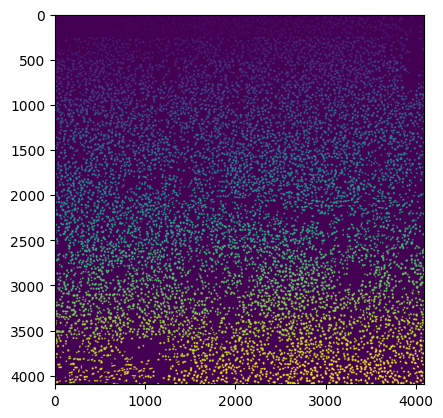

In [28]:
segments_array = np.array(segments)
plt.imshow(segments_array)

Loading in detected transcripts


In [33]:

transcripts_file = 'region_0/detected_transcripts.csv'
detected_tanscripts = pd.read_csv(os.path.join(experiment_path, transcripts_file))

In [39]:
micron_to_mosaic_pixel_transform_file = 'region_0/images/micron_to_mosaic_pixel_transform.csv'

In [40]:
def get_pixel_size(experiment_path: str) -> float:
    file = pd.read_csv(os.path.join(experiment_path, micron_to_mosaic_pixel_transform_file), index_col=None, header=None)
    return file

pixel_size = get_pixel_size(experiment_path).values

detected_tanscripts['global_x_pixels'] = (detected_tanscripts.global_x.values*(float(pixel_size[0][0].split()[0]))) + float(pixel_size[0][0].split()[2])
detected_tanscripts['global_y_pixels'] = (detected_tanscripts.global_y.values*(float(pixel_size[1][0].split()[1]))) + float(pixel_size[1][0].split()[2])

In [42]:
detected_tanscripts = detected_tanscripts[detected_tanscripts.global_y_pixels <20000]
detected_tanscripts = detected_tanscripts[detected_tanscripts.global_x_pixels <20000]

In [43]:
cell_assigments = segments[detected_tanscripts.global_z.values.astype(int), detected_tanscripts.global_y_pixels.values.astype(int), detected_tanscripts.global_x_pixels.values.astype(int)]

In [44]:
detected_tanscripts['nucleus_id'] = cell_assigments

In [54]:
sub_detected_tanscripts = detected_tanscripts[(detected_tanscripts.global_y_pixels > 5000) & (detected_tanscripts.global_y_pixels < 8000)]
sub_detected_tanscripts = sub_detected_tanscripts[(sub_detected_tanscripts.global_x_pixels > 5000) & (sub_detected_tanscripts.global_x_pixels < 8000)]

In [71]:
polyt = tifffile.imread(os.path.join(experiment_path, 'region_0/images/mosaic_PolyT_z3.tif'))


In [90]:
cellxgene = pd.crosstab(index=detected_tanscripts.nucleus_id, columns=detected_tanscripts.gene)

In [ ]:
metadata = detected_tanscripts[['global_x_pixels', 'global_y_pixels', 'nucleus_id']].groupby('nucleus_id').mean()[['global_x_pixels', 'global_y_pixels']]

In [103]:
import scanpy as sc
ad = sc.AnnData(X=cellxgene.values, var=pd.DataFrame(index=cellxgene.columns), obs=pd.DataFrame(index=cellxgene.index))


/home/amonell/miniforge3/envs/cellpose_dev/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [109]:
metadata.index = metadata.index.astype(str)

In [110]:
ad.obs = ad.obs.merge(metadata, left_index=True, right_index=True, how='left')

In [111]:
ad.obsm['X_spatial'] = ad.obs[['global_x_pixels', 'global_y_pixels']].values

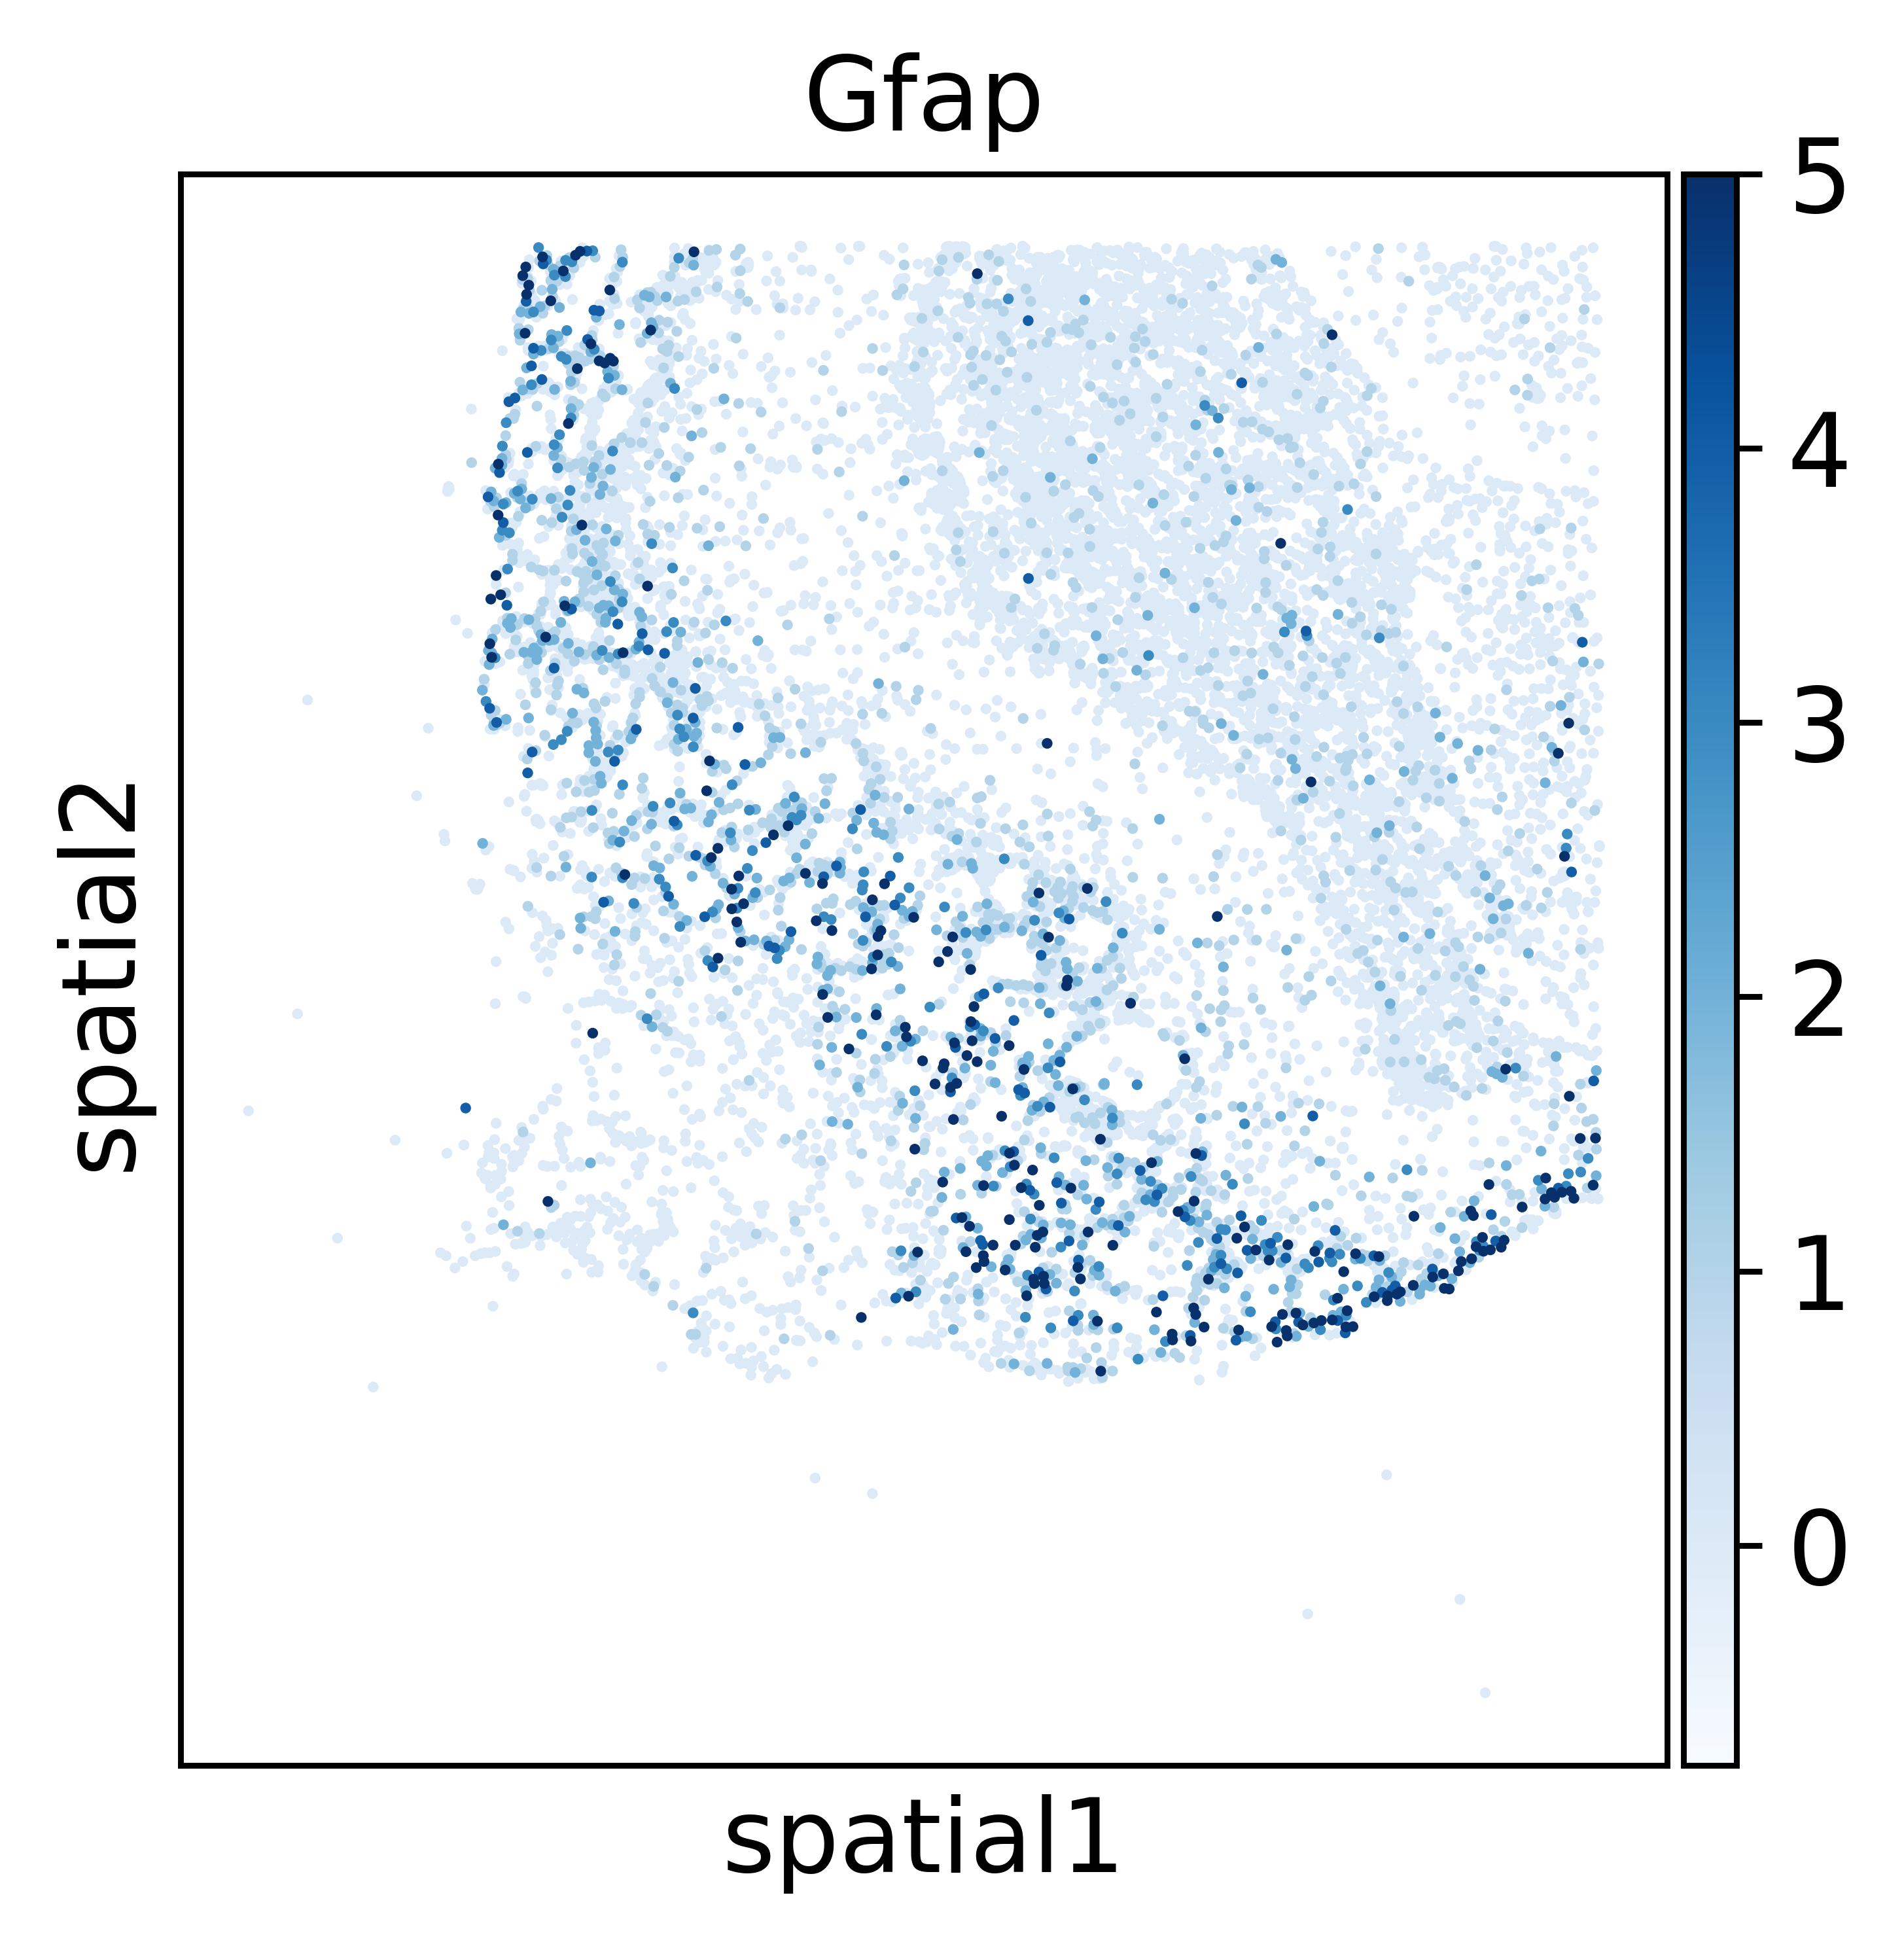

In [117]:
sc.set_figure_params(dpi=400)
sc.pl.embedding(ad, basis='spatial', color='Gfap', vmax = 5, cmap='Blues', vmin = -0.8)

In [83]:
np.unique(sub_detected_tanscripts.gene.isin(['Gfap']), return_counts=True)

(array([False,  True]), array([34146,   215]))

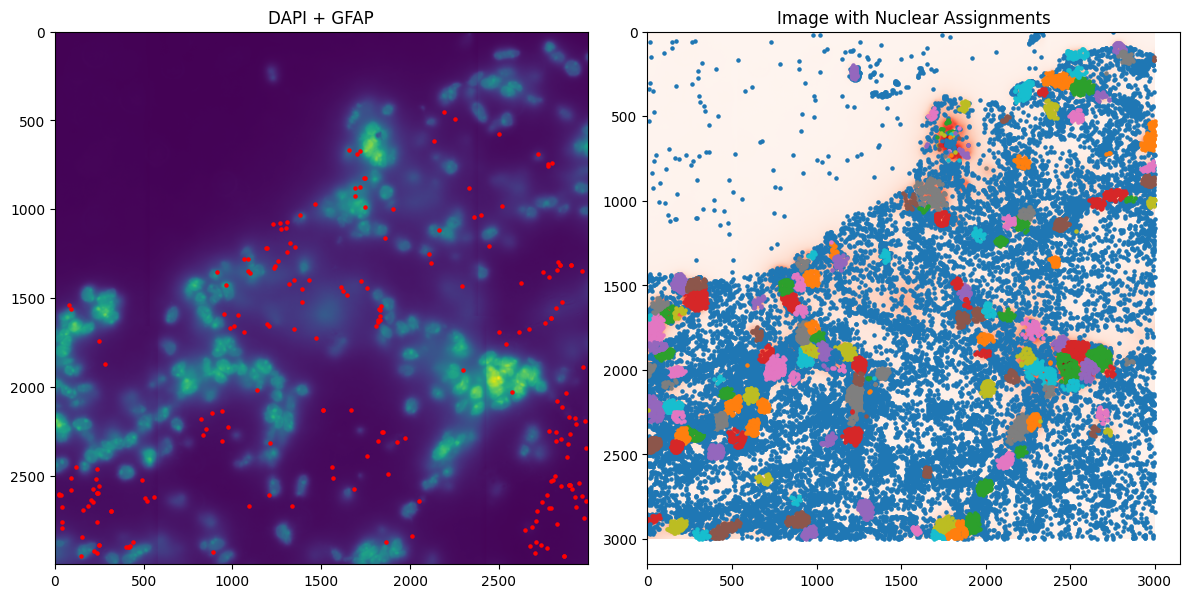

In [85]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Create categorical color mapping for nucleus IDs
unique_nuclei = sub_detected_tanscripts.nucleus_id.unique()
nucleus_colors = {nuc_id: f'C{i%10}' for i, nuc_id in enumerate(unique_nuclei)}
# First subplot - just the image
ax1.imshow(data_zarr[3][5000:8000, 5000:8000], cmap='viridis')
for nuc_id in unique_nuclei:
    mask = (sub_detected_tanscripts.nucleus_id == nuc_id) & (sub_detected_tanscripts.gene == 'Gfap')
    ax1.scatter(sub_detected_tanscripts[mask].global_x_pixels - 5000, 
               sub_detected_tanscripts[mask].global_y_pixels - 5000,
               c='red',
               label=f'Nucleus {nuc_id}',
               s=5, alpha=1)
ax1.set_title('DAPI + GFAP')

# Second subplot - image with scattered points
ax2.imshow(data_zarr[3][5000:8000, 5000:8000], cmap='Reds')



# Plot each nucleus ID with its categorical color
for nuc_id in unique_nuclei:
    mask = sub_detected_tanscripts.nucleus_id == nuc_id
    ax2.scatter(sub_detected_tanscripts[mask].global_x_pixels - 5000, 
               sub_detected_tanscripts[mask].global_y_pixels - 5000,
               c=nucleus_colors[nuc_id],
               label=f'Nucleus {nuc_id}',
               s=5, alpha=1)

ax2.set_title('Image with Nuclear Assignments')

plt.tight_layout()
plt.show()

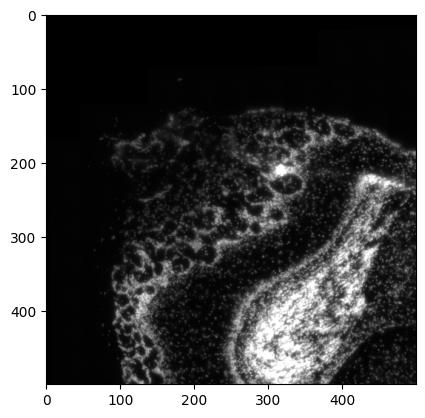

In [75]:
import matplotlib.pyplot as plt
import cv2

# Select channel 1 and convert to an appropriate data type if needed
channel = data_zarr[0]
# Define the thumbnail size (e.g., 500x500 pixels)
thumbnail = cv2.resize(channel, (500, 500), interpolation=cv2.INTER_AREA)
plt.imshow(thumbnail, cmap='gray', vmax = np.percentile(thumbnail, 99))  # adjust cmap if necessary
plt.show()

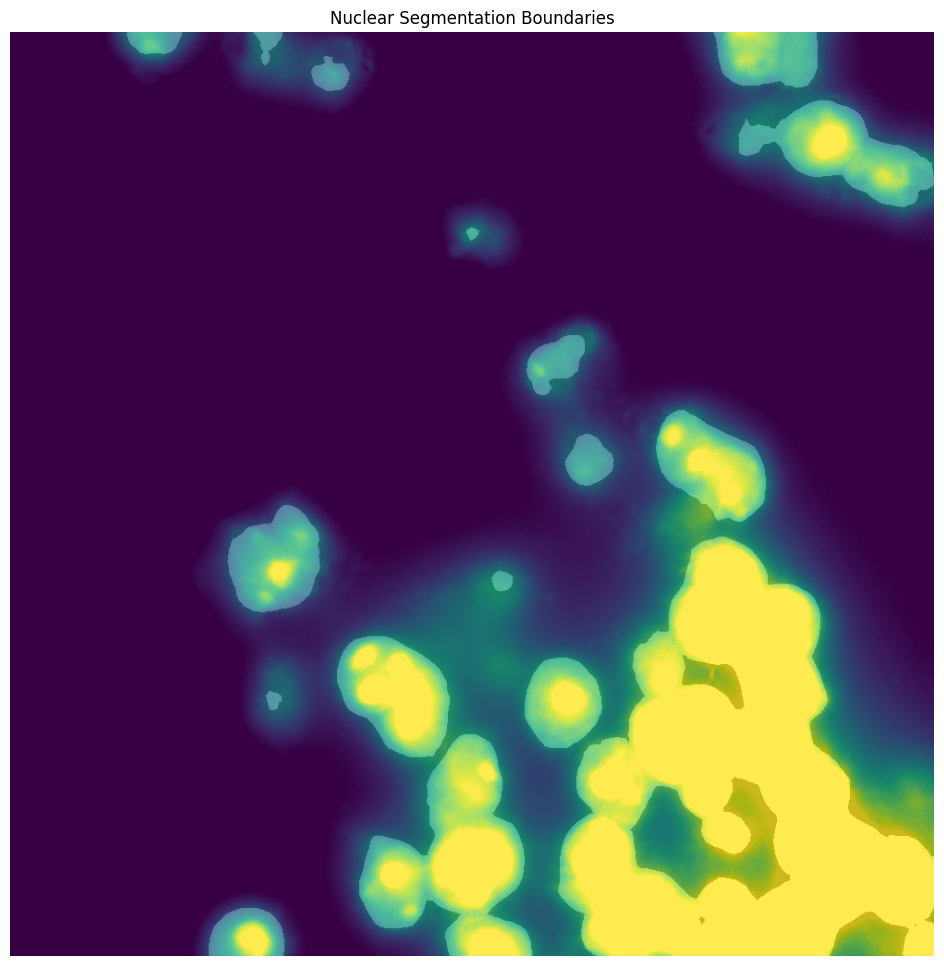

In [31]:
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

# Get the boundaries of the segmentation masks
boundaries = find_boundaries(segments[3][10000:11000, 10000:11000], mode='outer')

# Create figure and axis
fig, ax = plt.subplots(figsize=(12,12))

# Plot the underlying image in grayscale
ax.imshow(data_zarr[3][10000:11000, 10000:11000], cmap='viridis', vmax=12000, vmin=2000)

# Overlay the boundaries in red with some transparency
ax.imshow(np.clip(segments[3][10000:11000, 10000:11000], 0, 1), cmap='Grays_r', alpha=0.2)

plt.title('Nuclear Segmentation Boundaries')
plt.axis('off')
plt.show()


In [33]:
def run_cellpose(img: np.ndarray, model_path: str) -> (np.ndarray, np.ndarray, np.ndarray):
    use_GPU = core.use_gpu()
    model = models.CellposeModel(gpu=use_GPU, pretrained_model= model_path  )
    channels = [0,0]
    masks, flows, styles = model.eval([img], channels=channels, diameter=model.diam_labels,flow_threshold=0, cellprob_threshold=0, batch_size=1)
    return (masks, flows, styles)


In [34]:

masks_top_left, flows, styles = run_cellpose(
    data_numpy,
    model_path = mp,
    
)

In [ ]:
plt.imshow(masks_top_left[0])

In [27]:
chunk_per_axis = 2
mp = r'training/training_images/models/CP_20250205_202906'
masks_top_left, flows, styles = run_cellpose(
    maxed_xenium[:np.shape(maxed_xenium)[0]//chunk_per_axis, :np.shape(maxed_xenium)[1]//chunk_per_axis],
    model_path = mp,
)

masks_top_right, flows, styles = run_cellpose(
    maxed_xenium[:np.shape(maxed_xenium)[0]//chunk_per_axis, np.shape(maxed_xenium)[1]//chunk_per_axis:],
    model_path = mp,
)

masks_bottom_left, flows, styles = run_cellpose(
    maxed_xenium[np.shape(maxed_xenium)[0]//chunk_per_axis:, :np.shape(maxed_xenium)[1]//chunk_per_axis],
    model_path = mp,
)

masks_bottom_right, flows, styles = run_cellpose(
    maxed_xenium[np.shape(maxed_xenium)[0]//chunk_per_axis:, np.shape(maxed_xenium)[1]//chunk_per_axis:],
    model_path = mp,
)

In [28]:
constant = 1000000
full_mask = np.zeros_like(maxed_xenium[:, :], dtype=np.uint32)
full_mask[:np.shape(maxed_xenium)[0]//chunk_per_axis, :np.shape(maxed_xenium)[1]//chunk_per_axis] = masks_top_left[0]
full_mask[:np.shape(maxed_xenium)[0]//chunk_per_axis, np.shape(maxed_xenium)[1]//chunk_per_axis:] = masks_top_right[0] + (constant)
full_mask[np.shape(maxed_xenium)[0]//chunk_per_axis:, :np.shape(maxed_xenium)[1]//chunk_per_axis] = masks_bottom_left[0] + (constant*2)
full_mask[np.shape(maxed_xenium)[0]//chunk_per_axis:, np.shape(maxed_xenium)[1]//chunk_per_axis:] = masks_bottom_right[0] + (constant*3)

# when fullmask % constant == 0, set the value to 0
full_mask = np.where(full_mask % constant == 0, 0, full_mask)

Plot and save segmentation

In [ ]:
# save np array as png
tifffile.imsave(f'output/{experiment_name}_segmentation.png', full_mask.astype(np.uint16))

## Add the new segmentation to the transcripts.csv

In [ ]:
detected_transcripts = pd.read_csv(os.path.join(xenium_path, f'detected_transcripts_{experiment_name}.csv'), index_col=0)
detected_transcripts

Get the pixel to um conversion

In [ ]:
def get_pixel_size(path: str) -> float:
    file = pd.read_csv(os.path.join(path, f'micron_to_mosaic_pixel_transform_{experiment_name}.csv'), index_col=None, header=None)
    return file

pixel_size = get_pixel_size(xenium_path).values
pixel_size

In [26]:
detected_transcripts['global_x_pixels'] = (detected_transcripts.global_x.values*(float(pixel_size[0][0].split()[0]))) + float(pixel_size[0][0].split()[2])
detected_transcripts['global_y_pixels'] = (detected_transcripts.global_y.values*(float(pixel_size[1][0].split()[1]))) + float(pixel_size[1][0].split()[2])

In [ ]:
detected_cells = masks[0][detected_transcripts.global_y_pixels.values.astype(int), detected_transcripts.global_x_pixels.values.astype(int)]
detected_transcripts['cell_id'] = detected_cells
detected_transcripts['overlaps_nucleus'] = (detected_cells > 0).astype(int)
detected_transcripts

In [ ]:
plt.imshow(masks[0])
plt.scatter(detected_transcripts.global_x_pixels, detected_transcripts.global_y_pixels, cmap='tab20', s=1, alpha=0.02)

In [ ]:
detected_transcripts.global_y_pixels.values

In [34]:
detected_cells = masks[0][detected_transcripts.global_y_pixels.values.astype(int), detected_transcripts.global_x_pixels.values.astype(int)]

In [35]:
cross_tab = pd.crosstab(index=detected_cells,
                        columns=detected_transcripts['gene'].values)

In [36]:
cross_tab = cross_tab[np.array(cross_tab.index.tolist()) % 10000 != 0]

In [37]:
cross_tab = cross_tab[np.sum(cross_tab.values, axis=1) > 1]

In [ ]:
import scanpy as sc
adata = sc.AnnData(X=cross_tab.values, var=pd.DataFrame(index=cross_tab.columns), obs=pd.DataFrame(index=cross_tab.index.tolist()))

In [39]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color='Tmem119', vmax=4)

In [41]:
os.mkdir(os.path.join('output', f'{experiment_name}'))

In [42]:
adata.write(os.path.join('output', f'{experiment_name}', f'{experiment_name}_adata.h5ad'))

In [ ]:
image_compare = masks[0].astype(int)

unique_values = adata.obs.index.astype(float).astype(int)
cell_locations = np.unique(image_compare, return_index=True)

x_coord=cell_locations[1]//np.shape(image_compare)[0]
y_coord=cell_locations[1]%np.shape(image_compare)[1]

cells = cell_locations[0]
data = pd.DataFrame(zip(x_coord, y_coord), index=cells, columns=['x', 'y'])
xy_adata= data.loc[unique_values.tolist()].values

adata.obs['x'] = xy_adata[:,0]
adata.obs['y'] = xy_adata[:,1]

adata.obsm['X_spatial'] = xy_adata

sc.pp.calculate_qc_metrics(adata, inplace=True)

sc.pl.embedding(adata, basis='spatial', color='total_counts', size=20, vmax=3000)

adata.write(os.path.join('output', f'{experiment_name}', f'{experiment_name}_adata_processed.h5ad'))

In [46]:
detected_transcripts.to_csv(os.path.join('output', f'{experiment_name}', "transcripts_cellpose.csv"))